In [31]:
import sys
import os
import time
import re
import json
from urllib.parse import quote as urlencode
from urllib.request import urlretrieve

import http.client as httplib 

from astropy.table import Table,join
import numpy as np

import pprint
pp = pprint.PrettyPrinter(indent=4)
import SciServer
from SciServer import CasJobs, SkyQuery, SciDrive, SkyServer
import requests
import pandas as pd
import astropy as ap
import astropy.io.fits as astrofits
import astropy.io.votable as astrovot
import astropy.wcs as astrowcs
import astropy.units as astrounits
import astropy.coordinates as astrocoords
import astropy.visualization as astrovis
import astropy.visualization.mpl_normalize as astromplnorm
import astropy.nddata as astronddata
import astropy.nddata.utils as astrondutils
import io
import pdb 
from IPython.core.display import display

import matplotlib.pyplot as mplplot

import gzip
import tarfile

In [11]:
def mastQuery(request):
    """Perform a MAST query.
    
        Parameters
        ----------
        request (dictionary): The MAST request json object
        
        Returns head,content where head is the response HTTP headers, and content is the returned data"""
    
    server='mast.stsci.edu'

    # Grab Python Version 
    version = ".".join(map(str, sys.version_info[:3]))

    # Create Http Header Variables
    headers = {"Content-type": "application/x-www-form-urlencoded",
               "Accept": "text/plain",
               "User-agent":"python-requests/"+version}

    # Encoding the request as a json string
    requestString = json.dumps(request)
    requestString = urlencode(requestString)
    
    # opening the https connection
    conn = httplib.HTTPSConnection(server)

    # Making the query
    conn.request("POST", "/api/v0/invoke", "request="+requestString, headers)

    # Getting the response
    resp = conn.getresponse()
    head = resp.getheaders()
    content = resp.read().decode('utf-8')

    # Close the https connection
    conn.close()

    return head,content

In [12]:
def HscCrossmatch(data):
    
    crossmatchInput = {"fields":[{"name":"ra","type":"float"},
                                 {"name":"dec","type":"float"}],
                       "data":data}
    
    request = {"service":"Mast.Hsc.Crossmatch",
               "data":crossmatchInput,
               'params':{
                   "raColumn":"ra",
                   "decColumn":"dec",
                   'radius':0.001,
                   'cache-breaker':10},
               "pagesize":1000,
               "page":1,
               "format":"json",
               "removecache":True}
    
    headers,outString = mastQuery(request)
    outData = json.loads(outString)
    
    return outData

In [13]:
def mastJson2Table_Filt(jsonObj):
    filt = 'A_F475W'
    Obj = [x for x in jsonObj['data'] if x.get(filt,None) != None]
    mastDataTable = Table()

    for col,atype in [(x['name'],x['type']) for x in jsonObj['fields']]:
        mastDataTable[col] = np.array([x.get(col,None) for x in Obj])
    
    return mastDataTable

In [14]:
def mastJson2Table(jsonObj):

    dataTable = Table()

    for col,atype in [(x['name'],x['type']) for x in jsonObj['fields']]:
        dataTable[col] = np.array([x.get(col,None) for x in jsonObj['data']])
        
    return dataTable

In [15]:
def getHSCMatches(matchId):

#     data = result['data']

#     # get the match id
#     matchId = data[0]['MatchID']
#     print(type(matchId))
    # get detailed results for chosen match id
    request = {'service':'Mast.HscMatches.Db',
               'params':{'input':matchId,
                         'cache-breaker':10},
               'format':'json',
               'page':1,
               'pagesize':4}   

    headers,outString = mastQuery(request)

    outData = json.loads(outString)

    return outData

In [16]:
def genBundleRequest(imageNames, outfileNamePrefix='downloadBundle', extension='tar.gz'):
    baseUrl = "http://hla.stsci.edu/cgi-bin/getdata.cgi?config=ops&dataset="
    urlList = ",".join(['{}{}'.format(baseUrl, imageName) for imageName in imageNames])
    pathList = ['{}.fits'.format(imageName) for imageName in imageNames]

    request = {"service":"Mast.Bundle.Request",
               "params":{"urlList":urlList,
                         "filename":outfileNamePrefix,
                         "pathList":pathList,
                         "extension":extension,
                         'cache-breaker':10}
              }
    return request,outfileNamePrefix,extension

In [17]:
def downloadRequest(url):
    server='mast.stsci.edu'
    
    conn = httplib.HTTPSConnection(server)
    conn.request("GET", url)
    resp = conn.getresponse()
   
    fileName = resp.getheader('Content-Disposition')[21:]
    fileContent = resp.read()

    with open(fileName,'wb') as FLE:
        FLE.write(fileContent)

    conn.close()

    return fileName

In [ ]:
query = "SELECT dr8objid, ra, dec FROM zoo2MainSpecz"
result = CasJobs.executeQuery(query, 'DR12', format='pandas')
ra = result.ra.values
dec = result.dec.values
dr8objid = result.dr8objid.values
display(result)

In [51]:
from astroquery.mast import Catalogs
from astropy.coordinates import SkyCoord
import astropy.units import unit

catalogData = Catalogs.query_object("M10", radius=.02, catalog="HSC")

In [72]:
# os.chdir('/home/idies/workspace/persistent/JSON')
# bins = 500
# size = int(len(ra)/500)
# for i in range(size):
#     ra_dec_list = [{"ra":ras,"dec":decs} for ras,decs in zip(ra,dec)]
#     data = ra_dec_list[i*bins:(i*bins)+bins]
#     info = HscCrossmatch(data)
#     with open('Matching.txt', 'a+') as outfile:
#         json.dump(info, outfile)
#         outfile.write('\n')

In [19]:
os.chdir('/home/idies/workspace/persistent/JSON')
with open('Matching.txt') as f:
    lines = f.read().splitlines()
    f.close()
print(lines[0])

{"msg": "", "paging": {"page": 1, "rows": 16, "rowsTotal": 16, "pageSize": 1000, "rowsFiltered": 16, "pagesFiltered": 1}, "fields": [{"type": "float", "name": "ra"}, {"type": "float", "name": "dec"}, {"type": "int", "name": "MatchID"}, {"type": "float", "name": "distanceArcMin"}, {"type": "float", "name": "MatchRA"}, {"type": "float", "name": "MatchDec"}, {"type": "float", "name": "DSigma"}, {"type": "string", "name": "AbsCorr"}, {"type": "int", "name": "NumFilters"}, {"type": "int", "name": "NumVisits"}, {"type": "int", "name": "NumImages"}, {"type": "float", "name": "StartMJD"}, {"type": "float", "name": "StopMJD"}, {"type": "string", "name": "TargetName"}, {"type": "float", "name": "CI"}, {"type": "float", "name": "CI_Sigma"}, {"type": "float", "name": "KronRadius"}, {"type": "float", "name": "KronRadius_Sigma"}, {"type": "float", "name": "Extinction"}, {"type": "float", "name": "W2_F606W"}, {"type": "float", "name": "W2_F606W_Sigma"}, {"type": "int", "name": "W2_F606W_N"}, {"type":

In [50]:
from astropy.table import vstack
tables = [mastJson2Table(json.loads(line)) for line in lines]
bigtable = vstack(tables)

TableMergeError: The 'AbsCorr' columns have incompatible types: ['str32', 'str32', 'str32', 'str32', 'float64', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'float64', 'str32', 'str32', 'float64', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'float64', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'float64', 'str32', 'str32', 'str32', 'float64', 'str32', 'str32', 'str32', 'str32', 'str32', 'float64', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'float64', 'str32', 'str32', 'str32', 'str32', 'float64', 'str32', 'str32', 'float64', 'str32', 'str32', 'float64', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'float64', 'str32', 'float64', 'float64', 'str32', 'str32', 'str32', 'str32', 'str32', 'float64', 'str32', 'str32', 'float64', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'float64', 'str32', 'str32', 'float64', 'str32', 'str32', 'float64', 'str32', 'str32', 'float64', 'float64', 'str32', 'str32', 'str32', 'str32', 'float64', 'str32', 'float64', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'float64', 'str32', 'float64', 'str32', 'str32', 'str32', 'float64', 'str32', 'str32', 'str32', 'str32', 'float64', 'str32', 'str32', 'str32', 'float64', 'float64', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'float64', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'float64', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'float64', 'float64', 'str32', 'str32', 'float64', 'str32', 'str32', 'str32', 'float64', 'str32', 'float64', 'float64', 'str32', 'float64', 'str32', 'float64', 'str32', 'str32', 'str32', 'str32', 'str32', 'float64', 'str32', 'str32', 'str32', 'float64', 'str32', 'str32', 'str32', 'float64', 'float64', 'str32', 'str32', 'str32', 'str32', 'float64', 'str32', 'str32', 'str32', 'float64', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'float64', 'float64', 'str32', 'str32', 'float64', 'str32', 'str32', 'float64', 'str32', 'str32', 'str32', 'str32', 'float64', 'str32', 'str32', 'float64', 'str32', 'str32', 'float64', 'str32', 'str32', 'float64', 'float64', 'str32', 'float64', 'float64', 'str32', 'str32', 'float64', 'str32', 'float64', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'float64', 'str32', 'str32', 'str32', 'str32', 'float64', 'str32', 'str32', 'str32', 'str32', 'str32', 'float64', 'str32', 'str32', 'str32', 'str32', 'str32', 'float64', 'str32', 'float64', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'float64', 'float64', 'str32', 'float64', 'float64', 'float64', 'str32', 'float64', 'float64', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'float64', 'float64', 'float64', 'float64', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'float64', 'float64', 'str32', 'str32', 'float64', 'str32', 'str32', 'float64', 'float64', 'float64', 'str32', 'str32', 'str32', 'float64', 'float64', 'str32', 'float64', 'str32', 'str32', 'str32', 'float64', 'str32', 'str32', 'str32', 'str32', 'float64', 'str32', 'str32', 'str32', 'str32', 'float64', 'str32', 'float64', 'float64', 'float64', 'float64', 'float64', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'str32', 'float64', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'float64', 'float64', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'float64', 'str32', 'str32', 'str32', 'float64', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'float64', 'str32', 'str32', 'float64', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'float64', 'str32', 'str32', 'str32', 'float64', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'float64', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'float64', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'float64', 'str32', 'float64', 'float64', 'float64', 'str32', 'float64', 'str32', 'str32', 'str32', 'float64', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32', 'str32']

In [44]:
table1 = mastJson2Table(json.loads(lines[0]))
table2 = mastJson2Table(json.loads(lines[2]))
print(table2.keys())
print(table)

['ra', 'dec', 'MatchID', 'distanceArcMin', 'MatchRA', 'MatchDec', 'DSigma', 'AbsCorr', 'NumFilters', 'NumVisits', 'NumImages', 'StartMJD', 'StopMJD', 'TargetName', 'CI', 'CI_Sigma', 'KronRadius', 'KronRadius_Sigma', 'Extinction', 'W2_F300W', 'W2_F300W_Sigma', 'W2_F300W_N', 'W2_F450W', 'W2_F450W_Sigma', 'W2_F450W_N', 'W2_F606W', 'W2_F606W_Sigma', 'W2_F606W_N', 'W2_F814W', 'W2_F814W_Sigma', 'W2_F814W_N', '_selected_']
   ra       dec     MatchID ... W3_F160W_Sigma W3_F160W_N _selected_
-------- ---------- ------- ... -------------- ---------- ----------
199.5834  -1.091679  900328 ...           None       None       None
208.2269  -1.114616 1628511 ...              0          1       None
208.2269  -1.114616 1863709 ...              0          1       None
208.2269  -1.114616 1632242 ...              0          1       None
208.2269  -1.114616 1626871 ...              0          1       None
208.2269  -1.114616 1623433 ...              0          1       None
208.2269  -1.114616 1863717 

In [11]:



# test = json.loads(lines[1])
# astrotable = mastJson2Table(test)
#print(astrotable.keys())
pdtable = astrotable.to_pandas()
matches = getHSCMatches(str(pdtable.loc[0,'MatchID']))
astrotable1 = mastJson2Table(matches)
name = []
name.append(astrotable1[0]['ImageName'])

In [13]:
os.chdir('/home/idies/workspace/persistent/Images')
query,filename,extension = genBundleRequest(name)
pp.pprint(query)
headers,bundleString = mastQuery(query)
bundleInfo = json.loads(bundleString)

pp.pprint(bundleInfo)
downloadfile = downloadRequest(bundleInfo['url'])

{   'params': {   'extension': 'tar.gz',
                  'filename': 'downloadBundle',
                  'pathList': ['hst_13324_06_acs_wfc_f475w.fits'],
                  'urlList': 'http://hla.stsci.edu/cgi-bin/getdata.cgi?config=ops&dataset=hst_13324_06_acs_wfc_f475w'},
    'service': 'Mast.Bundle.Request'}
{   'bytesStreamed': 407543712,
    'fileStatusList': {   'http://hla.stsci.edu/cgi-bin/getdata.cgi?config=ops&dataset=hst_13324_06_acs_wfc_f475w': '{"status":"COMPLETE"}'},
    'manifestUrl': 'https://mast.stsci.edu/portal/Download/stage/anonymous/public/6bf65bdb-caa4-4c92-943c-c43ccd37e3ff/downloadBundle_MANIFEST.HTML',
    'progress': 1,
    'statusList': {   'http://hla.stsci.edu/cgi-bin/getdata.cgi?config=ops&dataset=hst_13324_06_acs_wfc_f475w': 'COMPLETE'},
    'url': 'https://mast.stsci.edu/portal/Download/stage/anonymous/public/6bf65bdb-caa4-4c92-943c-c43ccd37e3ff/downloadBundle.tar.gz'}


In [21]:
tar = tarfile.open("downloadBundle.tar.gz")
tar.extractall()
tar.close()

In [22]:
thisFile = "System.String[]"
base = os.path.splitext(thisFile)[0]
os.rename(thisFile, base + ".fits")

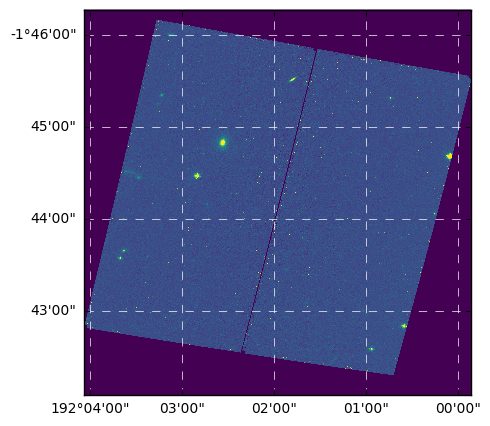

In [52]:
os.chdir('/home/idies/workspace/persistent/Images')
imageFigure = mplplot.figure(figsize=(5,5))
imageFits = astrofits.open('System.fits')
imageAxes = imageFigure.add_subplot(1,1,1, projection = astrowcs.WCS(imageFits[1].header))
imageNorm = astromplnorm.ImageNormalize(data=imageFits[1].data,interval=astrovis.ZScaleInterval(), stretch=astrovis.LinearStretch())
#print(imageFits[1].data)
imageAxes.imshow(imageFits[1].data, cmap='viridis', norm = imageNorm)
imageAxes.grid(color='white', ls='dashed')

In [19]:
from astropy.io import fits

In [20]:
hdu = fits.open('System.fits')

In [21]:
from astropy.coordinates import SkyCoord
import astropy.units as u


In [22]:
from astropy.wcs import WCS

In [23]:
hdu

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f4c036c4438>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f4c036c7a20>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f4c036d3c18>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f4c036d6d30>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7f4c0367fa90>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f4c03687e10>]

In [50]:
w = WCS(hdu[1].header); print(w)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 192.0327231037808  -1.736291512548394  
CRPIX : 2529.499999999838  2517.499999999839  
CD1_1 CD1_2  : -1.3888888888888e-05  0.0  
CD2_1 CD2_2  : 0.0  1.38888888888896e-05  
NAXIS : 5058  5034


In [25]:
coord = SkyCoord(ra=192.0427,dec=-1.747009,unit=(u.deg,u.deg),frame='icrs')

In [26]:
from astropy.nddata.utils import Cutout2D

In [41]:
cut = Cutout2D(hdu[1].data,position=coord,size=4*u.arcsec,wcs=w)

In [38]:
cut.wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 192.0327231037808  -1.736291512548394  
CRPIX : 729.4999999998381  782.499999999839  
CD1_1 CD1_2  : -1.3888888888888e-05  0.0  
CD2_1 CD2_2  : 0.0  1.38888888888896e-05  
NAXIS : 5058  5034

In [34]:
plt.add

AttributeError: module 'matplotlib.pyplot' has no attribute 'add'

In [39]:
import matplotlib.pyplot as plt

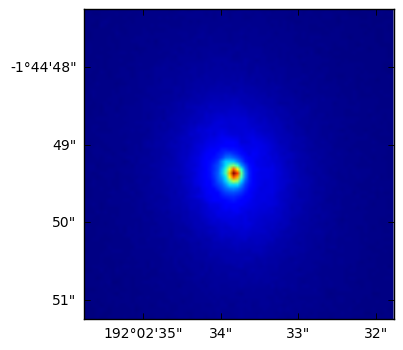

In [42]:
ax = plt.subplot(projection=cut.wcs);ax.imshow(cut.data,origin='lower')

In [31]:
import astropy;astropy.__version__

'3.0.3'